# Simulation of the Grid

In this chapter the grid can be simulated using the developed python tool.

```{admonition} See the Code
:class: seealso
The whole code is available in the [GitHub Repository](https://github.com/AndreGismo/SNEE-Projekt).
```

In [1]:
import pandapower as pp
from pandapower import networks as pn
from pandapower import plotting as pt
from pandapower.timeseries.data_sources.frame_data import DFData
import pandapower.control as control
import pandapower.timeseries as timeseries
import pandas as pd
from matplotlib import pyplot as plt

# custom libraries
from scenario import Scenario
from controllable_battery import ControllableBattery
from battery_controller import BatteryController
import pptools as ppt

# suppress annoying warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Necessary Preparations

### Creating the network

The first step is to create the network:

In [2]:
# create the kerber network
net = pn.create_kerber_vorstadtnetz_kabel_1()

And take a look at it:

````{margin}
```{admonition} Hint
:class: attention
The plot doesn't reflect the lengths of the lines, but the correct lengths are stored in the `net`
```
````

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


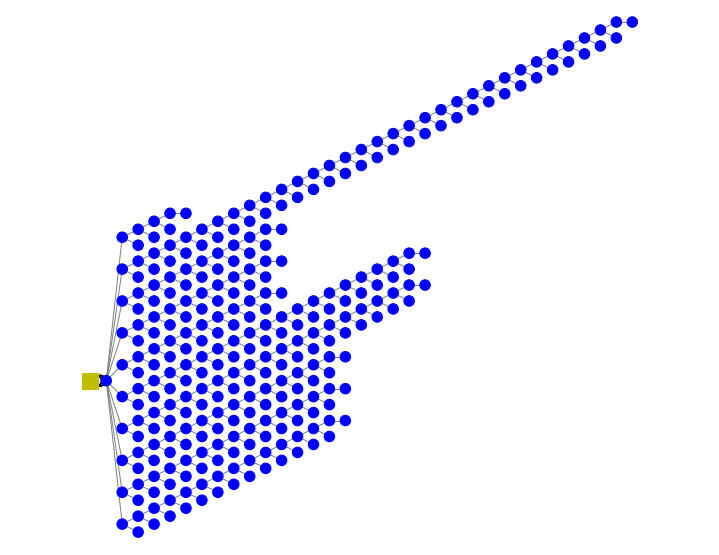

In [3]:
pt.simple_plot(net, library='igraph');

(settings)=
### Setting Parameters

As next step, some parameters determing the simulation have to be set:

- the resolution of the simulation (minimum 1 minute)
- whether to include some BEVs arriving at the same time
- whether to set all charging stations to the same nominal power
- whether to change the travelled distances
- setting the powerfactor of the SLP
- whether to activate controlling
- and finally setting the controlling parameters

__Set the resolution:__<br>
The `resolution` influences the $\Delta t$ from Equation [Equation 5](eq5) and thus the granularity of the whole simulation.

In [4]:
resolution = '15min'

__Make BEVs arrive at the same time:__<br>
This way it is possible to manipulate the arrival statistic depicted [Figure 5](fig5), allowing it to simulate extreme scenarios, where all the BEVs arrive at the same time.

In [5]:
same_arrival = False

# arrival_time needs to be set in multiples of quarter hours
arrival_time = 46

__Change the nominal power of the charging stations__:<br>
This way it is possible to manipulate the distibution of the nominal power of the charging stations.

In [6]:
same_power = False

# nominal charging power [kW]
loading_power = 11.1

__Change the travelled distance__:<br>
This makes it possible to adjust the travelled distance of the BEVs, thus determining the state of charge according to Equation [Equation 4](eq4) when the charging starts.

In [7]:
same_travelled = False

# travelled distance [km]
distance_travelled = 200

__Set the powerfactor of the SLP:__<br>
This makes it possible to simulate different powerfactors by adding reactive power to the SLP depicted in [Figure 3](fig3).

In [8]:
cosphi = 0.9

__Activate controlling:__<br>
This enables the controller.

In [9]:
controlling = False

__Set the controlling parameters:__<br>
This way the controlling parameters described in [here](controlling_paragraph).

In [10]:
if controlling:
    ControllableBattery.set_control_params('Ki', 1.5)
    ControllableBattery.set_control_params('Kd', 0.3)

### Creating a Scenario


````{admonition} Tip
:class: tip dropdown
It is also possible to create new scenarios using

```
scenario = Scenario(net, <penetration>)
```

However, this might change the underlying distributions (as the seed used for generating random choices isn't fixed). 
````

Next choose one of the [proposed scenarios](scenarios). The scenarios satisfy all of the [proposed distributions](distributions) but might be altered by the [settings choosen above](settings).

In [19]:
# 'Szenario0', 'Szenario30', 'Szenario50', 'Szenario80' or 'Szenario100'
scenario = Scenario.load_scenario('Szenario100')

## Running the Simulation

Now the simulation can be run:

In [20]:
if same_arrival:
    scenario.set_constant('time of arrival', arrival_time, inplace=True)
    
if same_power:
    scenario.set_constant('charging power [kW]', loading_power, inplace=True)

if same_travelled:
    scenario.set_constant('distance travelled [km]', distance_travelled, inplace=True)
    

data_nuernberg = pd.read_csv('Daten/Lastprofil/Nuernberg_absolut_final.csv')

data_nuernberg = ppt.set_simulation_range(data_nuernberg)

baseload = ppt.prepare_baseload(data_nuernberg, net, resolution)

batteries, datasource_bat = ppt.prepare_batteries(net, scenario, resolution)

loads = DFData(baseload)

# compute factor for share of Q out of P with cosphi
faktor = (1/cosphi**2 -1)**0.5

# data_source for reactive Power Q
loads_q = DFData(baseload * faktor)

# data_source for loading curves of BEVs
loads_bat = DFData(datasource_bat)

# creating controllers
load_controler = control.ConstControl(net, element='load', variable='p_mw',
                                      element_index=net.load.index,
                                      data_source=loads,
                                      profile_name=net.load.index)

load_controler_q = control.ConstControl(net, element='load', variable='q_mvar',
                                      element_index=net.load.index,
                                      data_source=loads_q,
                                      profile_name=net.load.index)

load_controller_bat = BatteryController(net, element='load', variable='p_mw',
                                        element_index=datasource_bat.columns,#loading_data.columns,
                                        data_source=loads_bat, batteries=batteries)

if controlling:
    load_controller_bat.activate_contolling()


# output writer 
writer = timeseries.OutputWriter(net, output_path="./",
                                 output_file_type=".csv")

# which variables to log
writer.log_variable(table='res_bus', variable='vm_pu')
writer.log_variable(table='res_line', variable='loading_percent')
writer.log_variable(table='res_trafo', variable='loading_percent')

# simulate timeseries
timeseries.run_timeseries(net)

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


Progress: |██████████████████████████████████████████████████| 100.0% Complete



## See the Results

First read in the stored results of the simulation:

In [21]:
results_bus = pd.read_csv('res_bus/vm_pu.csv', sep=';')*400
results_trafo = pd.read_csv('res_trafo/loading_percent.csv', sep=';')
results_line = pd.read_csv('res_line/loading_percent.csv', sep=';')

results_bus.index = pd.date_range(start='2020-12-13', freq=resolution,
                                  periods=len(results_bus))

results_line.index = pd.date_range(start='2020-12-13', freq=resolution,
                                  periods=len(results_bus))

results_trafo.index = pd.date_range(start='2020-12-13', freq=resolution,
                                  periods=len(results_bus))

# figure out critical line and bus
crit_bus = ppt.get_critical_bus(results_bus)
print(f'Maximal belasteter Bus: {crit_bus}')

crit_line = ppt.get_critical_line(results_line)
print(f'Maximal belastete Leitung: {crit_line}')

# configure layout of following plots
if int(resolution.rstrip('min')) >= 15:
    marker = 'x'

else:
    marker=None

Maximal belasteter Bus: 273
Maximal belastete Leitung: 220


### The Bus Voltage

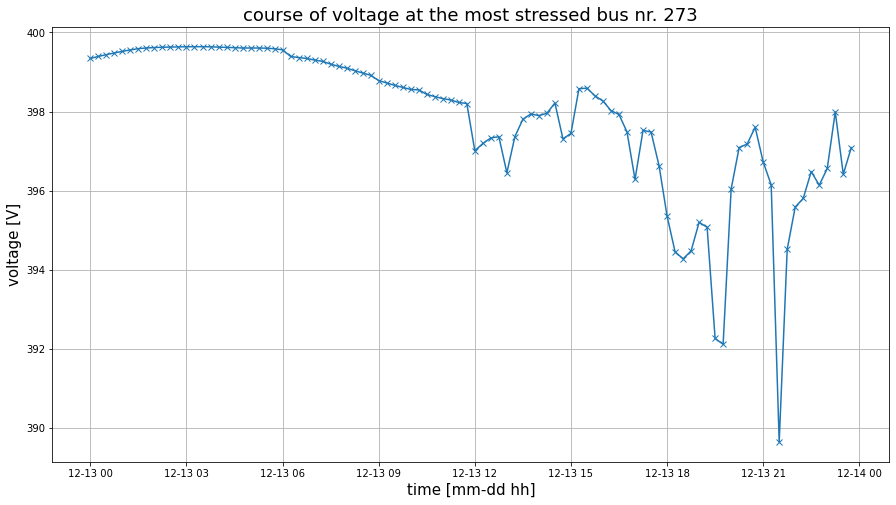

In [22]:
plt.figure(figsize=(15, 8))
plt.plot(results_bus[str(crit_bus)], marker=marker)
plt.title(f'course of voltage at the most stressed bus nr. {crit_bus}', fontsize=18)
plt.ylabel('voltage [V]', fontsize=15)
plt.xlabel('time [mm-dd hh]', fontsize=15)
plt.grid()

### The Line loading

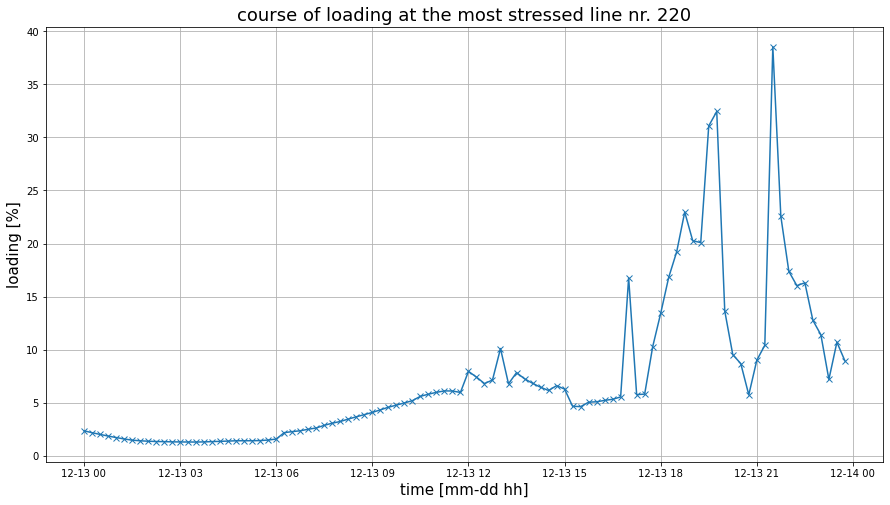

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(results_line[str(crit_line)], marker=marker)
plt.title(f'course of loading at the most stressed line nr. {crit_line}', fontsize=18)
plt.ylabel('loading [%]', fontsize=15)
plt.xlabel('time [mm-dd hh]', fontsize=15)
plt.grid()

### The Transformer Loading

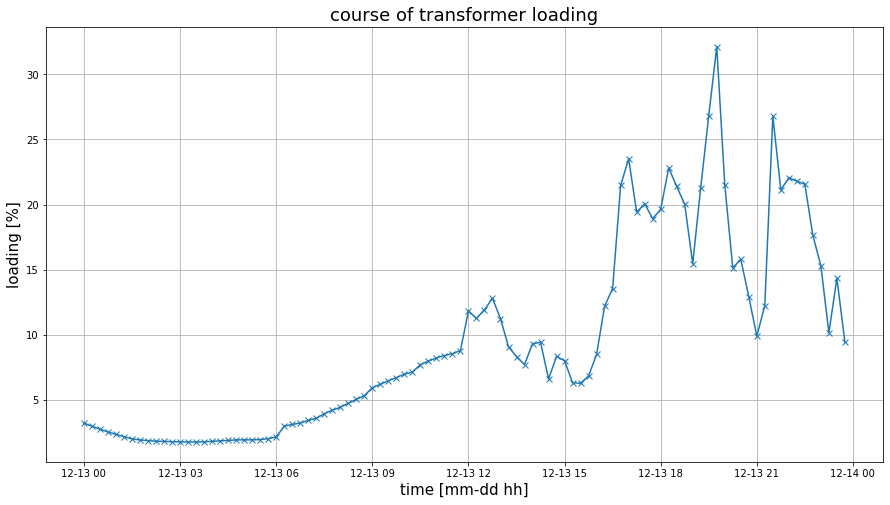

In [24]:
plt.figure(figsize=(15, 8))
plt.plot(results_trafo.iloc[:, 1], marker=marker)
plt.title(f'course of transformer loading', fontsize=18)
plt.ylabel('loading [%]', fontsize=15)
plt.xlabel('time [mm-dd hh]', fontsize=15)
plt.grid()